<a href="https://colab.research.google.com/github/ankesh86/PySparkNotebooks/blob/main/Unsupervised_NonHierarchical_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark==3.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317122 sha256=37fdfea729d199e9e8286e133eefa2f68a3133bb06685df82fe5efa47fd39f1c
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
# Import Sparksession
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("Clustering").getOrCreate()

In [3]:
# Print PySpark and Python versions
import sys
print('Python version: '+sys.version)
print('Spark version: '+spark.version)

Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Spark version: 3.4.0


# Load data

In [7]:
# Read data
file_location = "sample_data/cluster_data.csv"
file_type = "csv"
infer_schema = "false"
first_row_is_header = "true"


df = spark.read.format(file_type)\
.option("inferSchema", infer_schema)\
.option("header", first_row_is_header)\
.load(file_location)

In [8]:
#print metadata
df.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: string (nullable = true)
 |-- BALANCE_FREQUENCY: string (nullable = true)
 |-- PURCHASES: string (nullable = true)
 |-- ONEOFF_PURCHASES: string (nullable = true)
 |-- INSTALLMENTS_PURCHASES: string (nullable = true)
 |-- CASH_ADVANCE: string (nullable = true)
 |-- PURCHASES_FREQUENCY: string (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: string (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: string (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: string (nullable = true)
 |-- CASH_ADVANCE_TRX: string (nullable = true)
 |-- PURCHASES_TRX: string (nullable = true)
 |-- CREDIT_LIMIT: string (nullable = true)
 |-- PAYMENTS: string (nullable = true)
 |-- MINIMUM_PAYMENTS: string (nullable = true)
 |-- PRC_FULL_PAYMENT: string (nullable = true)
 |-- TENURE: string (nullable = true)



In [9]:
#count data
df.count()

8950

# Casting variable to appropriate data types

In [10]:
# Casting multiple variables
from pyspark.sql.types import *

#Identifying and assiging lists of variables
float_vars=list(set(df.columns) - set(['CUST_ID']))


for column in float_vars:
	df=df.withColumn(column,df[column].cast(FloatType()))

# Imputer

In [11]:
from pyspark.ml.feature import Imputer

# Shortlisting variables where mean imputation is required
input_cols=list(set(df.columns) - set(['CUST_ID']))

# Defining the imputer function
imputer = Imputer(
    inputCols=input_cols,
    outputCols=["{}_imputed".format(c) for c in input_cols])

# Applying the transformation
df_imputed=imputer.fit(df).transform(df)

# Dropping the original columns as we created the _imputed columns
df_imputed=df_imputed.drop(*input_cols)

# Renaming the input columns to original columns for consistency
new_column_name_list= list(map(lambda x: x.replace("_imputed", ""), df.columns))
df_imputed = df_imputed.toDF(*new_column_name_list)

# Normalizing and Pipeline

In [12]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml import Pipeline

# Listing the variables that are not required in the segmentation analysis
ignore = ['CUST_ID']
# creating vector of all features
assembler = VectorAssembler(inputCols=[x for x in df.columns if x not in ignore],
                            outputCol='features')
# creating the normalization for all features for scaling betwen 0 to 1
normalizer = Normalizer(inputCol="features", outputCol="normFeatures", p=1.0)
# Defining the pipeline
pipeline = Pipeline(stages=[assembler, normalizer])
# Fitting the pipeline
transformations=pipeline.fit(df_imputed)
# Applying the transformation
df_updated = transformations.transform(df_imputed)

# Model creation

In [13]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1003)
model = kmeans.fit(df_updated.select('normFeatures').withColumnRenamed('normFeatures','features'))

# Make predictions
predictions = model.transform(df_updated.select('normFeatures').withColumnRenamed('normFeatures','features'))

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.4985676444616938
Cluster Centers: 
[8.98299971e-02 4.07539038e-05 9.87267926e-02 2.07896083e-05
 5.52420719e-05 8.20280322e-02 1.37602987e-05 1.56132502e-01
 1.67607737e-01 1.35435512e-03 1.58877727e-03 1.27030958e-04
 3.68861785e-02 3.19938943e-01 4.51923000e-02 2.00543992e-05
 4.36753645e-04]
[4.21922052e-02 8.65612107e-05 1.56952070e-02 4.99595698e-06
 1.07504143e-04 6.73144634e-02 5.20319817e-05 9.19627812e-02
 4.12198014e-02 1.69559052e-03 2.36741330e-03 1.49505893e-04
 4.13390469e-02 6.69692711e-01 2.60219527e-02 2.03653144e-05
 7.78628562e-05]


# Plotting the graph and clusteing values

Silhouette with squared euclidean distance for 2 cluster solution = 0.4985676444616938
Silhouette with squared euclidean distance for 3 cluster solution = 0.5085437493303203
Silhouette with squared euclidean distance for 4 cluster solution = 0.47936391094272957
Silhouette with squared euclidean distance for 5 cluster solution = 0.45546028029107766
Silhouette with squared euclidean distance for 6 cluster solution = 0.41643403573982596
Silhouette with squared euclidean distance for 7 cluster solution = 0.461306382810158


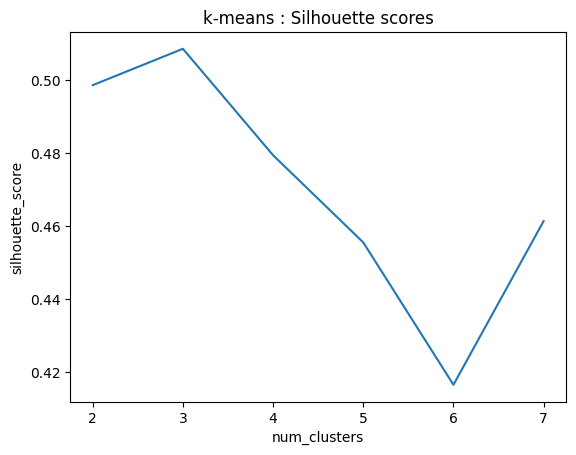

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sil_coeff=[]
num_clusters=[]
for iter in range(2,8):
    kmeans = KMeans().setK(iter).setSeed(1003)
    model = kmeans.fit(df_updated.select('normFeatures').withColumnRenamed('normFeatures','features'))
    # Make predictions
    predictions = model.transform(df_updated.select('normFeatures').withColumnRenamed('normFeatures','features'))
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    sil_coeff.append(silhouette)
    num_clusters.append(iter)
    print("Silhouette with squared euclidean distance for "+str(iter) +" cluster solution = " + str(silhouette))


df_viz=pd.DataFrame(zip(num_clusters,sil_coeff), columns=['num_clusters','silhouette_score'])
sns.lineplot(x = "num_clusters", y = "silhouette_score", data=df_viz)
plt.title('k-means : Silhouette scores')
plt.xticks(range(2, 8))
plt.show()